## Skoltech
## Intro to data science, fall 2020
## Assigment 2

### Goals
- Make exploratory data analysis
- Apply feature engineering and feature selection
- Try to solve classification task and use classification performance metrics
- Get the taste of gradient boosting approach


# Submiting the answers

Google form to submit your answers: https://docs.google.com/forms/d/1zwUO1KZNDTZYuD12dyMO3CaErGHnZuHx1Mdbo-c11ME/

Use your **skoltech email**. For Name, Surname use **exactly the same spelling** as in canvas system.

---

If your answer is a ``float number``, then it must be provided with **3 decimals after the floating point**, e.g. 1.234

---

If your answer is a ``list of float or integer numbers or str``, then they should be reported in descending (alphabetical) order,  divided by a comma, e.g.:

10.453,9.112,5.001,5.000

---

The last part (Q5) do not have corresponding fields in the google form. It is **not optional** and it will be graded manually from your .ipynb file.

---

If you have any questions regarding this Home Assignment, ask them piazza topic: https://piazza.com/class/kespugtqfrn12g?cid=29

#### Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Dataset
For the task we'll use kickstarter dataset. Kickstarter is the crowdfounding platform, where people can announce their project with financial goals and other can support the projects by paying the money ("pledging"). The goal will be to predict if the project will be successfull, i.e. would it achieve the funding goal. Let's take a brief look to the dataset.

In [4]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

In [3]:
df.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
135529,168820643,Critical Mass,Shorts,Film & Video,USD,2012-02-27,1000.0,2011-12-30 17:00:22,1120.00,successful,44,US,1120.00,1120.00,1000.0
333525,768949195,Beaded Wrapsody Bracelet Shop,Jewelry,Fashion,USD,2014-12-03,200.0,2014-11-03 21:35:28,212.00,successful,8,US,212.00,212.00,200.0
243078,306151431,My Smart Hydroponic Module Garden,Gadgets,Technology,USD,2017-02-15,25000.0,2017-01-26 01:43:14,680.00,failed,8,US,157.00,680.00,25000.0
173272,188125169,Orchestra Enigmatic: Season One,Classical Music,Music,USD,2012-10-18,8000.0,2012-09-18 00:50:20,1140.33,failed,32,US,1140.33,1140.33,8000.0
327505,737946037,The Story of Leon Coffee,Documentary,Film & Video,USD,2014-01-19,3000.0,2013-11-20 17:50:55,3075.00,successful,35,US,3075.00,3075.00,3000.0


In [4]:
df.shape

(378661, 14)

In [5]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# Section 1. Dataset acquaintance

-----

### Q1.1

#### How many NaN values are there in the dataset?

----

In [6]:
df.isnull().sum().sum()

3801

In [7]:
df = df.dropna(axis = 0)

----

Let us simplify the task a little bit: we are aiming to predict either project fails or not.
Thus 'success' projects will be encoded as 1, with state ['failed', 'canceled'] as 0 and we remove the rows with any other state.

### Q1.2 
#### How many '1' values are in resulting dataset (in state column)?

In [8]:
df['state'] = df['state'].apply(lambda x: '1' if x=='successful' else ('0' if x=='failed' else ('0' if x=='canceled'
                                                                 else ('x'))))

df = df.drop(df[(df.state == 'x')].index)
print(df.loc[df.state == '1', 'state'].count())
df = df.astype({'state' : 'int32'})

133851


-----

------

### Q1.3
#### Whats is a name of a project attracted the biggest pay check? (on average). Use column usd_pledged_real to judge. If there are multiple projects, choose any single one.

In [9]:
df['pay_check'] = df['usd_pledged_real']/df['backers']

df.pay_check.replace([np.nan, np.inf], 0, inplace=True)

df[['name', 'pay_check']].sort_values(by='pay_check', ascending=False).nlargest(1, 'pay_check').iloc[0, 0]

'Post Traumatic Stress (PTSD) Affects Us All'

-----

-----

### Q1.4
#### What is the most successful main category (in terms of success percentage)?

In [10]:
q14 = df.groupby('main_category').state.agg(['sum', 'count'])
q14['success_perc'] = q14['sum']/q14['count']
q14['success_perc'] = q14['success_perc'].apply(lambda x: x * 100)
q14.sort_values('success_perc', ascending=False)

,sum,count,success_perc
main_category,,,
Dance,2338,3736,62.580300
Theater,6534,10850,60.221198
Comics,5842,10720,54.496269
Music,24105,49101,49.092687
Art,11510,27862,41.310746
Film & Video,23612,62247,37.932752
Games,12518,34719,36.055186
Design,10549,29515,35.741149
Publishing,12300,39014,31.527144


In [11]:
print(q14.sort_values('success_perc', ascending=False).iloc[0])

sum             2338.0000
count           3736.0000
success_perc      62.5803
Name: Dance, dtype: float64


-----

-----

### Q1.5
#### Define the category with highest goal per project. How many projects belong to it?  (note: we use category here, not main_category)

In [12]:
q15 = df.groupby('category').goal.agg(['mean', 'count']).sort_values('mean', ascending=False)
q15.iloc[0]

mean     1.594601e+06
count    2.270000e+02
Name: Movie Theaters, dtype: float64

-----

-----

### Q1.6
#### What is the category with biggest total pledge? Use 'usd_pledged_real' to judge.

In [13]:
df.groupby('category').usd_pledged_real.max().sort_values(ascending=False)

category
Product Design     20338986.27
Tabletop Games     12393139.69
Gaming Hardware     8596474.58
Video Games         6333295.77
Sound               6225354.98
                      ...     
Printing              25150.30
Embroidery            18026.73
Taxidermy             15748.62
Residencies           15567.50
Crochet                7447.00
Name: usd_pledged_real, Length: 159, dtype: float64

------

------

As one can notice, there are both numerical and object-type data in our dataframe. 

We suggest you to split them to perform EDA separately. 

### Q1.7
#### Split columns to 'numeric' (by data type) and object-type. How many 'object-type' features are there?

In [14]:
q17 = df.select_dtypes(include=['object']).dtypes
q17.count()

7

In [15]:
df_object = pd.DataFrame(df, columns = ['name', 'deadline', 'main_category', 'currency',
              'deadline', 'launched', 'country'])

df_numeric = pd.DataFrame(df, columns = ['state', 'goal', 'pledged', 'backers', 'usd pledged',
              'usd_pledged_real', 'usd_goal_real', 'pay_check'])

### Q1.8
#### Let's do a bit of feature engineering. Let's create column 'pledge2goal' which define as ratio of usd_pledged_real to goal. How many outliers are there?
#### (We use a simple rule: an object is an outlier if it does not belong to [q25 - 1.5iqr, q75 + 1.5 iqr] interval, where qxx -- xx quantile, and iqr is inter-quantile range.)

In [16]:
df_numeric['pledge2goal'] = df_numeric['usd_pledged_real']/df_numeric['goal']

Q1 = df_numeric.pledge2goal.quantile(0.25)
Q3 = df_numeric.pledge2goal.quantile(0.75)
iqr = Q3 - Q1

q1outliers = df_numeric.pledge2goal < (Q1 - 1.5 * iqr)
q3outliers = df_numeric.pledge2goal > (Q3 + 1.5 * iqr)

outliers = q1outliers | q3outliers
outliers.value_counts()

False    351804
True      18415
Name: pledge2goal, dtype: int64

In [17]:
ind_outliers = outliers[outliers == True ].index

df_numeric.drop(ind_outliers, inplace = True)
df_object.drop(ind_outliers, inplace = True)

### Q1.9
#### Visualize the feature for success and fail cases. What can you say about received distributions? (use bins=10 or 20). Type letter as your answer
- A. Distributions intersect significantly, hard to say for sure that the ratio matters.
- B. Distributions have almost no intersection, the bigger ratio, the bigger success.
- C. Distributions intersect significantly, the bigger ratio, the bigger success
- D. Distributions have almost no intersection, the less ratio, the bigger success.

In [18]:
success_by_pledge2goal = df_numeric.loc[df_numeric['state'] == 1].pledge2goal
fail_by_pledge2goal = df_numeric.loc[df_numeric['state'] == 0].pledge2goal

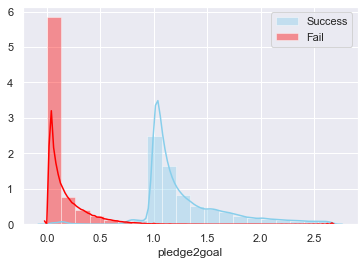

In [19]:
sns.distplot( success_by_pledge2goal , color="skyblue", label="Success", bins=20)
sns.distplot( fail_by_pledge2goal , color="red", label="Fail", bins=20)
plt.legend()

B. Distributions have almost no intersection, the bigger ratio, the bigger success.

-----

### Q1.10
#### Continue with plot from Q1.9. Where are the peaks located? We expect two numbers here as the answer

-----

In [20]:
[fail_by_pledge2goal.value_counts().idxmax(), success_by_pledge2goal.value_counts().idxmax()]

[0.0, 1.0]

-----

### Q1.11
#### Compute Pearson correlation coefficient between the pledge2real and target variable.

----

In [21]:
df_numeric.corr(method ='pearson')

,state,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,pay_check,pledge2goal
state,1.000000,-0.023853,0.151061,0.201237,0.197329,0.221998,-0.022714,0.143596,0.902114
goal,-0.023853,1.000000,0.012888,0.005921,0.010573,0.010819,0.939059,0.011318,-0.026670
pledged,0.151061,0.012888,1.000000,0.539310,0.569334,0.693046,0.006297,0.112367,0.142216
backers,0.201237,0.005921,0.539310,1.000000,0.809864,0.834607,0.006679,0.024120,0.233633
usd pledged,0.197329,0.010573,0.569334,0.809864,1.000000,0.941128,0.012157,0.139764,0.222616
usd_pledged_real,0.221998,0.010819,0.693046,0.834607,0.941128,1.000000,0.011822,0.164404,0.249617
usd_goal_real,-0.022714,0.939059,0.006297,0.006679,0.012157,0.011822,1.000000,0.012698,-0.024772
pay_check,0.143596,0.011318,0.112367,0.024120,0.139764,0.164404,0.012698,1.000000,0.153563
pledge2goal,0.902114,-0.026670,0.142216,0.233633,0.222616,0.249617,-0.024772,0.153563,1.000000


In [22]:
df_numeric.corr(method ='pearson').loc['state', 'pledge2goal']

0.9021138734010133

-----

### Q1.12
#### Visualize dependancy of numerical data with success. What can you say about it?

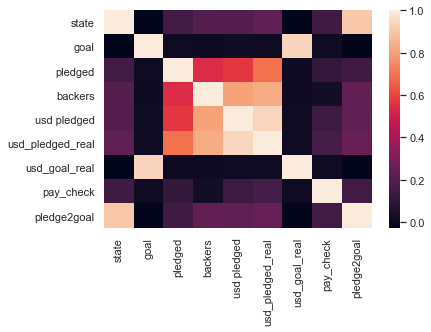

In [23]:
p1 = sns.heatmap(df_numeric.corr(method ='pearson'))

# Feature generation
Lets' generate some more feature that could be useful

### Q2.1 Create a year column that would hold the year. How many projects were in year 2012?

In [24]:
df['launched'] = pd.to_datetime(df['launched'])
df['year'] = df.launched.dt.year

df.year.value_counts().loc[2012]

41109

### Q2.2 Make a column 'duration_days' with number of full days from launch to deadline.
What is median value for this column?

In [25]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = df['deadline'] - df['launched']
df['duration_days'] = df['duration_days'].astype('timedelta64[D]')
df['duration_days'] = df['duration_days'].astype('int')

df.duration_days.median()

29.0

### Q2.3 Delete mistaken value from column 'country'. What is the value?

### Q2.4 Make column 'region' out of column country (america, europe, asia, oceania(including australiza/nz))
Where is the region with the worst conversion rate (percentage of successful projects)

In [26]:
df['region'] = ['america' if x=='US' or x=='CA' or x=='MX'
                else 'asia' if x=='HK' or x=='SG' or x=='JP'
                else 'oceania' if x=='AU' or x=='NZ'
                else 'europe' for x in df['country']]

df.region.value_counts()

america    305809
europe      54188
oceania      9106
asia         1116
Name: region, dtype: int64

In [27]:
q24 = df.groupby('region').state.agg(['sum', 'count'])
q24['success_perc'] = q24['sum']/q24['count']
q24['success_perc'] = q24['success_perc'].apply(lambda x: x * 100)
q24.sort_values('success_perc', ascending=True)

,sum,count,success_perc
region,,,
oceania,2458,9106,26.993191
europe,17163,54188,31.673064
asia,401,1116,35.931900
america,113829,305809,37.222253


### Q2.5 For each main_category leave only the three most popular category and replace other with "other"
What is the most frequent subcategory for design?

In [28]:
q25 = df.groupby('main_category')['category'].value_counts().reset_index(name='Count')

q25_1 = q25.groupby('main_category')[['category', 'Count']].apply(pd.DataFrame.nlargest, n=3, columns=['Count'])
products_list = q25_1.category.tolist()
df['category'] = df['category'].apply(lambda x: 'other' if x not in  products_list else x)
q25_1

category  Count
main_category                             
Art           0                 Art   8155
              1            Painting   3262
              2        Illustration   3125
Comics        13             Comics   4973
              14        Comic Books   2707
              15     Graphic Novels   1839
Crafts        19             Crafts   4603
              20        Woodworking   1150
              21                DIY   1126
Dance         34              Dance   2314
              35       Performances   1000
              36             Spaces    195
Design        39     Product Design  21886
              40             Design   4122
              41     Graphic Design   1990
Fashion       46            Fashion   8474
              47            Apparel   7029
              48        Accessories   3080
Film & Video  55        Documentary  16065
              56             Shorts  12303
              57       Film & Video   9149
Food          75               Food  11395
              76        Restaurants   2775
              77             Drinks   2367
Games         88     Tabletop Games  14036
              89        Video Games  11689
              90              Games   3171
Journalism    96         Journalism   1717
              97                Web   1219
              98              Print    719
Music         102             Music  13208
              103              Rock   6717
              104        Indie Rock   5639
Photography   121       Photography   5729
              122        Photobooks   1565
              123            People   1082
Publishing    128           Fiction   9107
              129        Nonfiction   8259
              130  Children's Books   6711
Technology    146        Technology   6742
              147              Apps   6239
              148               Web   3836
Theater       162           Theater   7036
              163             Plays   1363
              164           Musical    906

### Q2.6 create the columns "name_length" with length of the name.
What is the biggets length?

In [29]:
df["name_length"] = df.name.apply(len)
df.name_length.max()

96

# Preprocessing

### Q3.1 Drop the leaking columns
Based on what we have already seen, can you assume what features are leakeges? What is the columns? Drop them


In [30]:
df = df.drop('usd_pledged_real', 1)
df = df.drop('usd pledged', 1)
df = df.drop('pledged', 1)
df = df.drop('pay_check', 1)
df = df.drop('backers', 1)

### Q3.2 Deal with the categorical features.
Lets drop some more columns for now (name, deadline, launched, country, usd_goal_real). Note: you can re-use these columns in the Q5 section. 
Preprocess the rest of categorical columns. How many columns do you have now?

In [31]:
df = df.drop(['name', 'deadline', 'launched', 'country', 'usd_goal_real'], 1)

In [32]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

cat_features = ['category', 'main_category', 'currency', 
               'year', 'region']
num_features = ['goal', 'duration_days', 'name_length']

X = df.copy()

encoded_features = pd.DataFrame(ohe.fit_transform(X[['category', 'main_category', 'currency', 
               'year', 'region']]))

ind_df = df.index

In [33]:
category_cols = [f'category{cat}' for cat in ohe.categories_[0]]
main_category_cols = [f'main_category{cat}' for cat in ohe.categories_[1]]
currency_cols = [f'currency{cat}' for cat in ohe.categories_[2]]
year_cols = [f'year{cat}' for cat in ohe.categories_[3]]
region_cols = [f'region{cat}' for cat in ohe.categories_[4]]

In [34]:
dummy_cols_names = [*category_cols, *main_category_cols, 
                   *currency_cols, *year_cols,
                   *region_cols]
encoded_features.columns = dummy_cols_names
encoded_features.index = ind_df

In [35]:
X.drop(['category', 'main_category',
       'currency', 'year', 'region'], axis=1, inplace=True)

In [36]:
X = pd.concat([X, encoded_features], axis=1)

In [37]:
X.shape

(370219, 93)

### Q3.3 Split the dataset
Separate the target column (state) without stratification and with random state 42 and test size 0.2. How many of successful projects in train set?

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X.drop(['state'], axis=1, inplace=True)

In [40]:
y = df['state']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [42]:
y_train.value_counts()

0    189041
1    107134
Name: state, dtype: int64

### Q3.4 Scale the numeric columns with standard scaler
What is max number in goal field after scaling?

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])
X[num_features] = scaler.transform(X[num_features])

<ipython-input-44-1e536dfee750>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_features] = scaler.transform(X_train[num_features])
C:\Users\ramaz\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-44-1e536dfee750>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [45]:
X.goal.value_counts().max()

28832

# Feature selection

### Q4.1 Estimate feature importance by Anova
What is the two most important features by anova with f classifier?

------

In [46]:
from sklearn.feature_selection import SelectKBest, f_classif

In [47]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X, y)

SelectKBest(k=2)

In [48]:
scores = selector.scores_
X_columns = X.columns
important_features = pd.DataFrame(data=scores, index = X_columns, columns = ['Importance'])
important_features.Importance.sort_values(ascending=False)

main_categoryMusic         4151.217287
main_categoryTechnology    3844.516792
main_categoryTheater       2826.093892
year2015                   2520.238235
categoryTabletop Games     2516.616561
                              ...     
currencyGBP                   0.492528
categoryProduct Design        0.489086
main_categoryGames            0.163857
categorySpaces                0.135144
regionasia                    0.024039
Name: Importance, Length: 92, dtype: float64

------

## Build a model with logistic regression

Use l2 penalty and search for optimal C in np.logspace(-2, 4, 7).

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [50]:
pipe = make_pipeline(LogisticRegression(penalty='l2'))
parameters = {'logisticregression__C' : np.logspace(-2, 4, 7)
}
grid = GridSearchCV(pipe, param_grid=parameters, verbose=50, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4

KeyboardInterrupt: 

### Q4.2 What is an optimal C for l2 regularization?

In [ ]:
grid.best_params_

### Q4.3 What is the accuracy for this params?

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print(accuracy_score(y_pred, y_test))

### Q4.4 What is the two most important features by logistic regression estimation?

In [ ]:
model1 = LogisticRegression(C=100, penalty='l2', n_jobs=-1)
model1.fit(X_train, y_train)
LR_feature = model1.coef_[0]

In [ ]:
LR_importance = pd.DataFrame({'feature': X_train.columns, 'score': LR_feature})
LR_importance.sort_values(by='score').head(2)

### Q4.5 Build roc curve and calculate roc-auc score. What is the roc-auc score?

In [ ]:
model1 = LogisticRegression(penalty='l2', C=100, n_jobs=-1).fit(X_train, y_train)

In [ ]:
y_prob = model1.predict_proba(X_test)
y_prob = y_prob[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.step(fpr, tpr, color='b', alpha=0.2,
        where='post')
plt.fill_between(fpr, tpr, alpha=0.2, color='b')

print(roc_auc_score(y_test, y_prob))


------

------

## Build a random forest model
Use random state 42, maximum depth from 2 to 15, and number of estimators in `[10, 20, 50, 100, 200]`

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe2 = make_pipeline(RandomForestClassifier(random_state=42))
parameters = {'randomforestclassifier__n_estimators' : np.array([10,20,50,100,200]),
              'randomforestclassifier__max_depth' : np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
}
grid1 = GridSearchCV(pipe2, param_grid=parameters, verbose=50, n_jobs=-1)
grid1.fit(X_train, y_train)

### Q4.6 What is an optimal depth and number of trees?

In [ ]:
grid1.best_params_

### Q4.7 What is the accuracy for this params?

In [ ]:
y_pred1 = grid1.best_estimator_.predict(X_test)
print(accuracy_score(y_pred1, y_test))

### Q4.8 Build precision-recall curve. What is the precision for recall 0.5?

In [ ]:
model2=RandomForestClassifier(random_state=42, max_depth=15, n_estimators=100).fit(X_train, y_train)

In [ ]:
y_prob1 = model2.predict_proba(X_test)
y_prob1 = y_prob1[:, 1]

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score

precision, recall, _ = precision_recall_curve(y_test, y_prob1)
plt.step(recall, precision, color='b', alpha=0.2, where='post')

plt.plot(recall_score(y_test, y_pred1), 
         precision_score(y_test, y_pred1)
         )
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [ ]:
np.argmin(recall >= 0.5)

In [ ]:
prec = pd.DataFrame(precision)

In [ ]:
prec.iloc[47575]

### Q4.9 What is the two most important features by random forest?

In [ ]:
RF_feature = model2.feature_importances_

In [ ]:
RF_importance = pd.DataFrame({'feature': X_train.columns, 'score': RF_feature})
RF_importance.sort_values(by='score', ascending=False).head(2)

------

------

# Build the stronger model

### Q5.1 Generate two (or more) meaningfull features

I decided to create a feature "couple_year" instead of "year". I may be kind of cheating, but I remove 6 rows with year==1970.
Also I added feature "country".

In [ ]:
new = df[['year']].copy()
new['y'] = pd.Series(y, index=new.index)

In [ ]:
df_new = pd.read_csv('ks-projects-201801.csv')
df_new.set_index("ID", inplace=True)

In [ ]:
df_new = df_new.dropna(axis=0)
df_new.shape

In [ ]:
df_new['state'] = df_new['state'].apply(lambda x: '1' if x=='successful' else ('0' if x=='failed' else ('0' if x=='canceled' else ('x')))) 
df_new = df_new.drop(df_new[(df_new.state == 'x')].index)

In [ ]:
new['country'] = pd.Series(df_new.country, index=new.index)

In [ ]:
#Drop 1970
new = new[new.year != 1970]
new.year.value_counts()

In [ ]:
new['couple_year'] = ['9-10' if x==2009 or x==2010
                    else '11-12' if x==2011 or x==2012
                    else '13-14' if x==2013 or x==2014
                    else '15-16' if x==2015 or x==2016
                    else '17-18' for x in new['year']]

In [ ]:
new_ohe = OneHotEncoder(sparse=False)
new_encoded_features = pd.DataFrame(new_ohe.fit_transform(new[['country', 'couple_year']]))

new_ind_df = new.index

In [ ]:
сountry_cols = [f'country{cat}' for cat in new_ohe.categories_[0]]
couple_year_cols = [f'couple_year{cat}' for cat in new_ohe.categories_[1]]

new_dummy_cols_names = [*сountry_cols, 
                        *couple_year_cols] 
new_encoded_features.columns = new_dummy_cols_names 
new_encoded_features.index = new_ind_df

In [ ]:
new = pd.concat([new, new_encoded_features], axis=1)

new.drop(['country', 'couple_year', 'year'], axis=1, inplace=True)

In [ ]:
X_new = X[X.year1970 != 1]
X_new = X_new.drop(['year1970'], axis=1)

y_new = new['y']
new = new.drop(['y'], axis=1)

X_new = pd.concat([X_new, new], axis=1)

In [ ]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

### Q5.2 Train an xgboost, that's beat random forest

In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
XGB = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=-1)

In [ ]:
model3 = XGB.fit(X_new_train, y_new_train)

In [ ]:
y_pred3 = model3.predict(X_new_test)
print(accuracy_score(y_pred3, y_new_test))